# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
data.shape

(891, 11)

In [7]:
#How many females and males are there in the dataset?
pd.DataFrame({'number': data['Sex'].value_counts(),'fraction':data['Sex'].value_counts(normalize=True)})

,number,fraction
male,577,0.647587
female,314,0.352413


In [8]:
#What about the survived passengers?
pd.DataFrame({'number': data['Survived'].value_counts(),'fraction':data['Survived'].value_counts(normalize=True)})

,number,fraction
0,549,0.616162
1,342,0.383838


In [9]:
#Is there any relationship between the gender and the survival?
data.groupby('Sex')['Survived'].value_counts().unstack().join(data.groupby('Sex')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Sex,,,
female,81,233,0.742038
male,468,109,0.188908


__Conclusion:__ there were 891 passengers on board (from trainning dataset), 65% of them were male, 38% of all passengers survived. But if we look at the survival ratio inside male and female groups we'll find out that females were more likely to surive (74% ratio) than males (19% ratio).

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<function matplotlib.pyplot.show(close=None, block=None)>

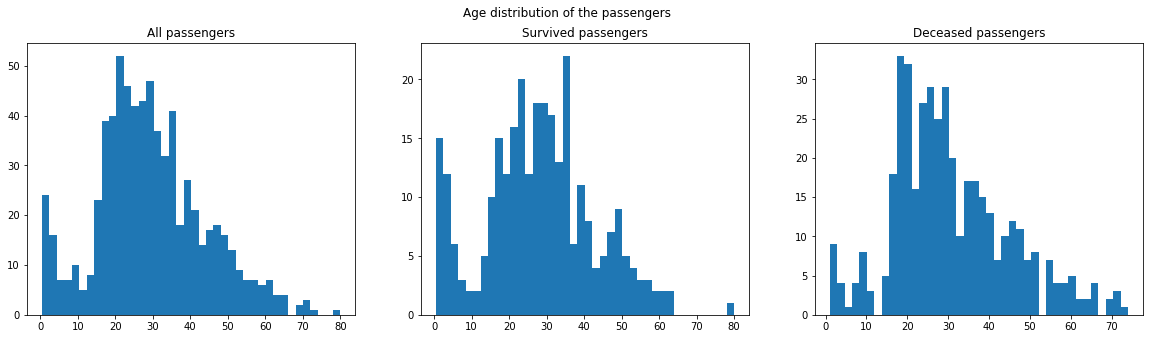

In [10]:
#Plot age distribution of the passengers.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Age distribution of the passengers')
ax1.hist(data['Age'], bins=40)
ax1.set_title('All passengers')
ax2.hist(data.loc[data['Survived'] == 1]['Age'], bins=40)
ax2.set_title('Survived passengers')
ax3.hist(data.loc[data['Survived'] == 0]['Age'], bins=40)
ax3.set_title('Deceased passengers')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

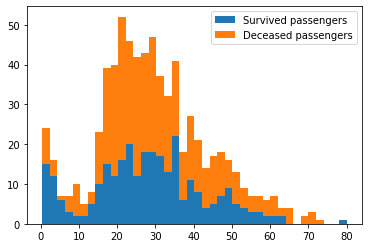

In [11]:
plt.hist([data.loc[data['Survived'] == 1]['Age'], data.loc[data['Survived'] == 0]['Age']], bins=40, stacked=True, label=['Survived passengers','Deceased passengers'])
plt.legend()
plt.show

In [12]:
#What is the average and the median age of survived and deceased passengers?
data.groupby('Survived')['Age'].agg(['mean','median'])

,mean,median
Survived,,
0,30.626179,28.0
1,28.343690,28.0


__Conclusion:__
Age distributions differ for survived and deceased passengers because
* places in lifeboats were first of all distributed to *children* and women
* elderly people have worse health and physical form

Thus there are relatively more survived children and less seniors.

__P.S.__ One more thing to mention is that distribution of Age is not normal (mean is biased towards young) which is not good for modelling.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [13]:
#What class was "the safest"?
data.groupby('Pclass')['Survived'].value_counts().unstack().join(data.groupby('Pclass')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Pclass,,,
1,80,136,0.629630
2,97,87,0.472826
3,372,119,0.242363


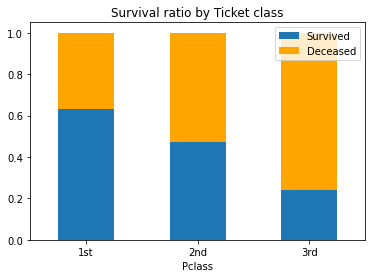

In [14]:
data1 = data.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack()\
.rename(index={1: '1st', 2: '2nd', 3: '3rd'})
data1.loc[:,1].plot(kind='bar',label='Survived')
data1.loc[:,0].plot(kind='bar',bottom=data1.iloc[:,1],color='orange',label='Deceased')
plt.legend()
plt.xticks(rotation='horizontal')
plt.title('Survival ratio by Ticket class')
plt.show()

In [15]:
#Is there any relationship between the embarkation port and the survival?
data.groupby('Embarked')['Survived'].value_counts().unstack().join(data.groupby('Embarked')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Embarked,,,
C,75,93,0.553571
Q,47,30,0.389610
S,427,217,0.336957


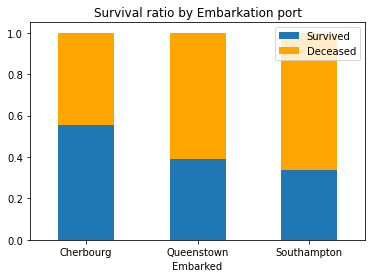

In [16]:
data2 = data.groupby('Embarked')['Survived'].value_counts(normalize=True).unstack()\
.rename(index={'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})
data2.loc[:,1].plot(kind='bar',label='Survived')
data2.loc[:,0].plot(kind='bar',bottom=data2.iloc[:,1],color='orange',label='Deceased')
plt.legend()
plt.xticks(rotation='horizontal')
plt.title('Survival ratio by Embarkation port')
plt.show()

__Conclusion:__ We found out that the descending order of safety upon "passenger class" is 1st-2nd-3rd and upon "Embarkation port" is 'Cherbourg'-'Queenstown'-'Southampton'. The difference in classes' survival ratio may be connected with their location (3rd class was probably flooded first) and status of passengers (rich were resqued first). The difference in "Embarked" survival ratio is harder to explain - I would suppose that passengers from different ports have different 1) nationality and 2) social status - these factors could bring the difference (mainly for 'Cherbourg').

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [17]:
data.isnull().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [18]:
data.join(data['Cabin'].isnull(),rsuffix='_is_Null').groupby('Cabin_is_Null')['Survived'].value_counts(normalize=True).unstack()

Survived,0,1
Cabin_is_Null,,
False,0.333333,0.666667
True,0.700146,0.299854


In [19]:
data.join(data['Age'].isnull(),rsuffix='_is_Null').groupby('Age_is_Null')['Survived'].value_counts(normalize=True).unstack()

Survived,0,1
Age_is_Null,,
False,0.593838,0.406162
True,0.706215,0.293785


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

__Conclusion:__ There are 3 features with missed values: Age, Cabin and Embarked.

First thing we need to say is that missing values could also bring value in this case. If we don't know some information about the passenger the reason could be that this person died and we couldn't ask him about his 'Age' or 'Cabin'. So firstly I would try to treat 'nan' as a separate value.

'Age' category is numeric so we can also fill missing values with mean or median.

'Embarked' percentage of missing values is low (0.2%) so we can drop NaNs.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

## Feature preparation

In [20]:
data['Deck'] = data.apply(lambda x: 'is_null' if str(x.Cabin)=='nan' else x.Cabin[0], axis=1)

In [21]:
data.groupby('Deck')['Survived'].value_counts().unstack().join(data.groupby('Deck')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Deck,,,
A,8.0,7.0,0.466667
B,12.0,35.0,0.744681
C,24.0,35.0,0.593220
D,8.0,25.0,0.757576
E,8.0,24.0,0.750000
F,5.0,8.0,0.615385
G,2.0,2.0,0.500000
T,1.0,NaN,0.000000
is_null,481.0,206.0,0.299854


In [22]:
data['Age_group'] = data.apply(lambda x: 'is_null' if str(x.Age)=='nan' else \
                               'children' if x['Age'] < 16 else \
                               'adults' if x['Age'] <= 60 else \
                               'seniors', axis=1)

In [23]:
data.groupby('Age_group')['Survived'].value_counts().unstack().join(data.groupby('Age_group')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Age_group,,,
adults,373,236,0.387521
children,34,49,0.590361
is_null,125,52,0.293785
seniors,17,5,0.227273


In [24]:
data['Family'] = data['SibSp'] + data['Parch']
data['Family_group'] = data.apply(lambda x: '0' if x['Family'] < 1 else '1-3' if x['Family'] < 4 else  '4-', axis=1)

In [25]:
data.groupby('Family_group')['Survived'].value_counts().unstack().join(data.groupby('Family_group')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Family_group,,,
0,374,163,0.303538
1-3,123,169,0.578767
4-,52,10,0.161290


In [26]:
data['Title'] = data['Name'].str.extract(r', (.{1,15})\. ')

In [27]:
data.groupby('Title')['Survived'].value_counts().unstack().join(data.groupby('Title')['Survived'].mean())\
.set_axis(['Died', 'Survived','Survival ratio'], axis=1)

,Died,Survived,Survival ratio
Title,,,
Capt,1.0,NaN,0.000000
Col,1.0,1.0,0.500000
Don,1.0,NaN,0.000000
Dr,4.0,3.0,0.428571
Jonkheer,1.0,NaN,0.000000
Lady,NaN,1.0,1.000000
Major,1.0,1.0,0.500000
Master,17.0,23.0,0.575000
Miss,55.0,127.0,0.697802


In [28]:
# Fill 'Age' missed values with average
data['Age'].fillna(data['Age'].mean(), inplace=True)

# Drop 'Embarked' missed values
data.dropna(subset=['Embarked'], inplace=True)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Age_group,Family,Family_group,Title
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,is_null,adults,1,1-3,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,adults,1,1-3,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,is_null,adults,0,0,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,adults,1,1-3,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,is_null,adults,0,0,Mr


In [29]:
features = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Age_group', 'Family_group', 'Title']

In [30]:
y = data['Survived']

Make the same feature transformations for test set

In [31]:
#performing the same for test data
data_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [32]:
data_test['Deck'] = data_test.apply(lambda x: 'is_null' if str(x.Cabin)=='nan' else x.Cabin[0], axis=1)

In [33]:
data_test['Age_group'] = data_test.apply(lambda x: 'is_null' if str(x.Age)=='nan' else \
                                         'children' if x['Age'] < 16 else \
                                         'adults' if x['Age'] <= 60 else \
                                         'seniors', axis=1)

In [34]:
data_test['Family'] = data_test['SibSp'] + data_test['Parch']
data_test['Family_group'] = data_test.apply(lambda x: '0' if x['Family'] < 1 else '1-3' if x['Family'] < 4 else  '4-', axis=1)

In [35]:
data_test['Title'] = data_test['Name'].str.extract(r', (.{1,15})\. ')

In [36]:
data_test.isnull().mean()

Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.205742
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.002392
Cabin           0.782297
Embarked        0.000000
Deck            0.000000
Age_group       0.000000
Family          0.000000
Family_group    0.000000
Title           0.000000
dtype: float64

In [37]:
# Fill 'Age' missed values with average
data_test['Age'].fillna(data_test['Age'].mean(), inplace=True)

Encode categorical features

In [38]:
data_total = pd.concat([data, data_test])

In [39]:
# Encode categorical features
encoder = OneHotEncoder()
enc_features = features
encoder.fit(data_total[enc_features])
X = pd.DataFrame(encoder.transform(data[enc_features]).toarray()\
                       , index=data.index\
                       , columns=encoder.get_feature_names(input_features=enc_features))
X_test = pd.DataFrame(encoder.transform(data_test[enc_features]).toarray()\
                       , index=data_test.index\
                       , columns=encoder.get_feature_names(input_features=enc_features))

## Modelling

In [40]:
# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1)
cross_val_score(logreg, X, y, scoring='accuracy', cv=5).mean()

0.8279375357074843

In [41]:
# KNN
knn = KNeighborsClassifier()
cross_val_score(knn, X, y, scoring='accuracy', cv=5).mean()

0.815552593156859

__Conclusion:__ logistic regression with L2 regularization performs slightly better in terms of accuracy than KNN with 5 neighbors.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Using `GridSearchCV` for hyperparameter tuning with roc_auc scoring

In [42]:
# Logistic Regression

lr_param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0], 'penalty': ['l1', 'l2']}
logreg_grid = GridSearchCV(logreg, lr_param_grid, scoring = "roc_auc")
logreg_grid.fit(X, y)
print(logreg_grid.best_estimator_)

LogisticRegression(C=0.5, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')


In [43]:
print(accuracy_score(y,logreg_grid.predict(X)))

0.8357705286839145


In [44]:
# KNN

knn_param_grid = {'n_neighbors': list(range(1,30)), 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(knn, knn_param_grid, scoring = "roc_auc")
knn_grid.fit(X, y)
print(knn_grid.best_estimator_)

KNeighborsClassifier(n_neighbors=18)


In [45]:
print(accuracy_score(y,knn_grid.predict(X)))

0.8357705286839145


Combining Logistic Regression and KNN

In [46]:
selection_model = LogisticRegression(solver='liblinear', penalty='l1', random_state=42)
selector = SelectFromModel(selection_model).fit(X, y)
X_pruned = selector.transform(X)

knn_param_grid = {'n_neighbors': list(range(1,30)) , 'weights': ['uniform', 'distance']}
knn_grid_selection = GridSearchCV(knn, knn_param_grid, scoring = "roc_auc")
knn_grid_selection.fit(X_pruned, y)
print(knn_grid_selection.best_score_)
print(knn_grid_selection.best_estimator_)

0.8673827454251091
KNeighborsClassifier(n_neighbors=16)


In [47]:
print(accuracy_score(y,knn_grid_selection.predict(X_pruned)))

0.8402699662542182


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [48]:
#Survived_pred_logreg = pd.DataFrame({'Survived': logreg_grid.predict(X_test)}, index=data_test.index)
#Survived_pred_knn = pd.DataFrame({'Survived': knn_grid.predict(X_test)}, index=data_test.index)
Survived_pred_knn_selection = pd.DataFrame({'Survived': knn_grid_selection.predict(selector.transform(X_test))}, index=data_test.index)

#Survived_pred_logreg.to_csv('pred_logreg3.csv')
#Survived_pred_knn.to_csv('pred_knn3.csv')
Survived_pred_knn_selection.to_csv('pred_knn_selection3.csv')

__Note:__ my kaggle nickname is __eugene.sinevich__, my score is __0.78708__

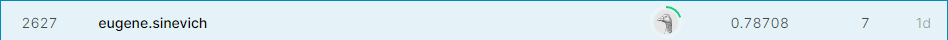

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code